# Section 1. Preparing the Data

### 1.1. Loading required passages (TensorFlow, NumPy, Pandas, CV2)

Importing needed packages.

**Essential Note:**
If you would like to test _Keras Facenet Feature Extraction_ which I use here, you should use older versions of _Keras_, _TensorFlow_, and probably _Python_ as well. 

**My configuration of kernel for Keras Facenet:**
- TensorFlow: 1.14.0
- Keras: 2.3.1
- Python: 3.6.2

_P.S. That was quite painful to find this configuration and avoid all the conflicts :D_

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow image preprocessing 
from tensorflow.keras.preprocessing import image as image_preprocessing
import tensorflow.keras.backend as tf_backend 
tf_backend.set_image_data_format('channels_last')

# Importing fetch_lfw_people dataset from the sklearn.datasets package
from sklearn.datasets import fetch_lfw_people

# Import all other needed packages
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import face_recognition
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


### 1.2. Loading images dataset for checking the accuracy

Note, that if you are trying to run this notebook, run only one block from either **Option 1** or **Option 2**.

**Option 1.** Importing `fetch_lfw_people` dataset from `sklearn.datasets`

In [ ]:
# Importing dataset
lfw_people_dataset = fetch_lfw_people(min_faces_per_person=80, color=True)

# Settings images
people_images = lfw_people_dataset.images
# Setting labels
people_labels = lfw_people_dataset.target

**Option 2**. Importing `lfw` [dataset](http://vis-www.cs.umass.edu/lfw/) from the folder

In [2]:
# Importing needed packages
import glob

# Specifying path to the images
lfw_dataset_path = './Images/lfw'
# Getting array of subpaths
lfw_people_subpaths = [subdirectory[0] for subdirectory in os.walk(lfw_dataset_path)]
# Setting minimal amount of faces needed for one person
faces_per_person = 60

people_images, people_labels = [], []

# Going along the array
for person_id, subpath in enumerate(lfw_people_subpaths[1:]):
    subpath_images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob(subpath + '/*.jpg')]
    if len(subpath_images) < faces_per_person:
        continue

    for image in subpath_images[:faces_per_person]:
        people_images.append(image)
    
    people_labels += [person_id] * faces_per_person
    
# Checking if loading was completed
print(np.shape(people_images))

(480, 250, 250, 3)


Converting `lfw_people` and `lfw_people_labels` to the np array 

In [3]:
people_images_np = np.array(people_images, dtype = float)
print('Shape of images dataset:', people_images_np.shape)

Shape of images dataset: (480, 250, 250, 3)


Displaying the dataset to check whether we initialized everything properly

In [4]:
def display_images(images, image_ids, gallery_size=3, figure_size = 10):
    """
    Displays a gallery of pictures
    
    Input: 
    images, image_ids - array of images of shape (m, n_H, n_W, n_C) and corresponding ids
    gallery_size - number of images per row to be displayed (total size is gallery_width x gallery_width)
    figure_size - size of images to be displayed
    """
    
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(gallery_size**2):
        subplot = plt.subplot(gallery_width, gallery_width, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title("id=" + str(image_ids[i]))
        plt.axis("off")

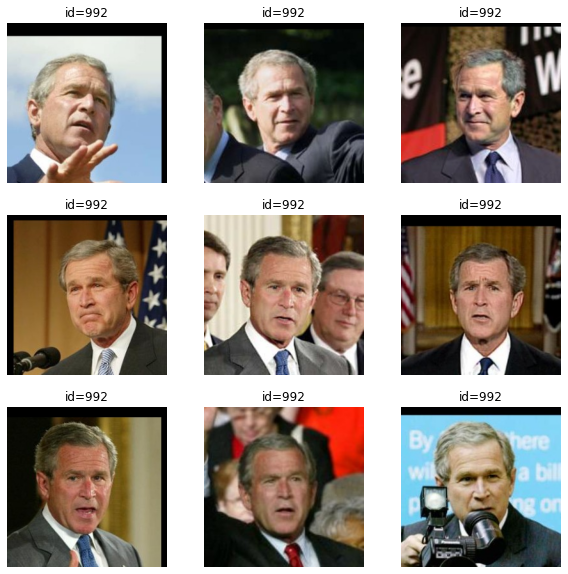

In [5]:
gallery_offset = 0 # Can be changed to "move" the gallery
gallery_width = 3 # Can be changed to resize gallery

display_images(
    people_images_np[(gallery_offset):(gallery_width**2 + gallery_offset)], 
    people_labels[(gallery_offset):(gallery_width**2 + gallery_offset)])

### 1.3. Forming batches of images of the same person

In [6]:
def form_batch_by_id(images, labels, image_id):
    """
    Get array of images of a person with specified id from the dataset
    
    Input: 
    images - array of images of shape (m, n_H, n_W, n_C)
    labels - array of labels (integers)
    image_id - id of a desired set of images
    
    Output: 
    image_batch - array of images of a person with id=person_id of shape (k, n_H, n_W, n_C)
    """
    
    _, image_height, image_width, image_channels = images.shape
    image_batch = np.empty((0, image_height, image_width, image_channels))
    
    assert len(labels) == images.shape[0], 'Labels length should match the number of images'
    
    for i in range(len(labels)):
        if labels[i] == image_id:
            image_to_concatenate = np.expand_dims(images[i], axis=0)
            image_batch = np.concatenate((image_batch, image_to_concatenate), axis=0)
            
    return image_batch

Batch shape (60, 250, 250, 3)


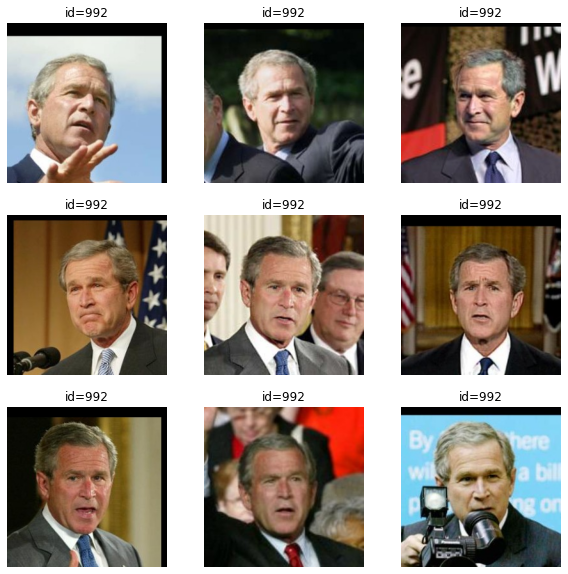

In [7]:
person_id = 992 # Person's ID to be displayed
batch = form_batch_by_id(people_images_np, people_labels, image_id=person_id) # Getting images of a person

print('Batch shape', batch.shape) # Check whether the shape is correct

# Displaying a gallery
display_images(
    batch[:(gallery_width**2)], 
    np.full((gallery_width**2), person_id, dtype=int), 
    gallery_size=3)

In [8]:
INFTY = 10000000

def form_batches_list(images, labels):
    """
    Form set of batches in which the images correspond to one single ID
    
    Input: 
    images - set of images of shape (m, n_H, n_W, n_C)
    labels - set of labels of size m
    
    Output:
    image_batches - batches of images with the same id (which equals to the index in an array)
    """
    
    image_batches = []
    for person_id in np.unique(labels):
        image_batches.append(form_batch_by_id(images, labels, person_id))
        
    return image_batches

def form_batches_numpy(images, labels, dataset = 'sklearn_lfw_people'):
    """
    Same as form_batches_list, but creates a batch of shape (m, k, n_H, n_W, n_C) 
    where m is a number of batches, k is a minimum size among all batches
    
    Input: 
    images, labels -- same as for form_batches_list
    dataset -- either 'local_lfw_people' or 'sklearn_lfw_people'
    
    Output: a set of shape (m, k, n_H, n_W, n_C)
    """
    
    if dataset == 'local_lfw_people':
        # As the size of images batches is already normalize, we just simply convert it
        return np.array(images)
    elif dataset == 'sklearn_lfw_people': 
        # Form list of batches
        batches_list = form_batches_list(images, labels) 

        # Get minimum size of a batch
        min_batch_size = INFTY
        for batch in batches_list:
            min_batch_size = min(min_batch_size, batch.shape[0])

        _, image_height, image_width, image_channels = np.shape(images)
        batches_list_numpy = np.empty((0,min_batch_size,image_height,image_width,image_channels))

        for batch in batches_list:
            batch_to_concatenate = np.expand_dims(batch[:min_batch_size], axis=0)
            batches_list_numpy = np.concatenate((batches_list_numpy, batch_to_concatenate), axis=0)

        return batches_list_numpy
    
    return None

Number of batches: 8
Shape of selected batch: (60, 250, 250, 3)
Shape of numpy list of batches: (8, 60, 250, 250, 3)


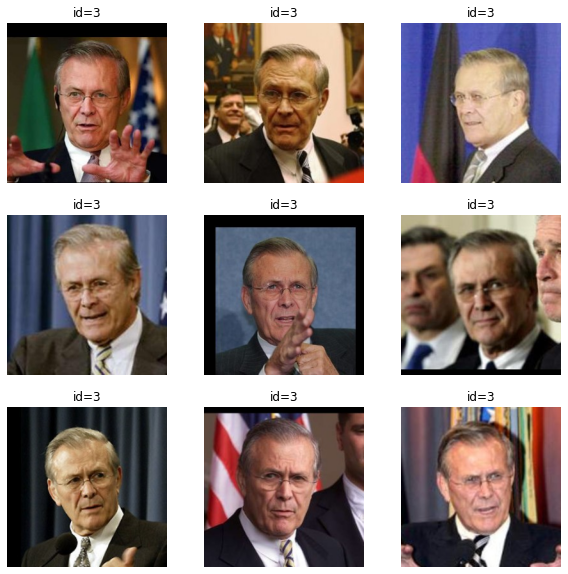

In [9]:
# Distributing images into batches of the same id
image_batches = form_batches_list(people_images_np, people_labels)
# Id of a batch to display in the gallery
image_batch_display_id = 3

# Trying to use form_batches_numpy
image_batches_numpy = form_batches_numpy(people_images_np, people_labels, dataset='sklearn_lfw_people')

# Displaying a gallery
display_images(
    image_batches_numpy[image_batch_display_id][:(gallery_width**2)], 
    np.full((gallery_width**2), image_batch_display_id, dtype=int), 
    gallery_size=3)

# Printing some info to verify that everything was implemented properly
print('Number of batches:', len(image_batches))
print('Shape of selected batch:', image_batches[image_batch_display_id].shape)
print('Shape of numpy list of batches:', image_batches_numpy.shape)

# Section 2. Extracting features from an image using Keras Facenet

#### Loading model's weights and model itself

In [10]:
model = keras.models.load_model('models/facenet_keras.h5', compile=False)

Suppose we have a batch of size $n_b$ with images $I^{(1)}, I^{(2)}, \dots, I^{(n_b)}$.
Using FaceNet, we can extract a feature vector of dimension $n_f$, that is:
$$
f(I^{(j)}) = \begin{pmatrix} f(I^{(j)})_1 \\ f(I^{(j)})_2 \\ \vdots \\ f(I^{(j)})_{n_f} \end{pmatrix}
$$
To evaluate difference $d(I^{(m)}, I^{(k)})$ between images $I^{(m)}$ and $I^{(k)}$ we are going to simply take a square of the feature-vectors difference norm:
$$
d(I^{(m)}, I^{(k)}) = \| f(I^{(m)}) - f(I^{(k)}) \|^2 = \sum_{j=1}^{n_f} (f(I^{(m)})_j - f(I^{(k)})_j)^2
$$

### Section 2.1 (Optinal). Segmenting face from the picture

In [11]:
def segment_image(image):
    image = image.astype("uint8")
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) == 0:
        return 'SEGMENT_ERROR'
    
    top, right, bottom, left = face_locations[0]
    return np.array(Image.fromarray(image).crop((left, top, right, bottom)))

def segment_batches(image_batches):
    """
    Return the same batch, but with segmented images
    """
    
    new_batches = []
    
    for batch in image_batches:
        new_batch = []
        for image in batch:
            new_image = segment_image(image)
            if new_image != 'SEGMENT_ERROR':
                new_batch.append(segment_image(image))
            
        new_batches.append(new_batch)
    
    return new_batches

def normalize_batches_size(image_batches):
    """
    Makes the batch of the single size
    """
    
    normalized_batches = []
    # Get minimum size of a batch
    min_batch_size = INFTY
    for batch in image_batches:
        min_batch_size = min(min_batch_size, np.shape(batch)[0])

    for batch in image_batches:
        normalized_batches.append(batch[:min_batch_size])

    return normalized_batches

In [12]:
# Segmenting batches (OPTIONAL)
image_batches_segmented = segment_batches(image_batches)

Normalized batches array shape (8, 59)


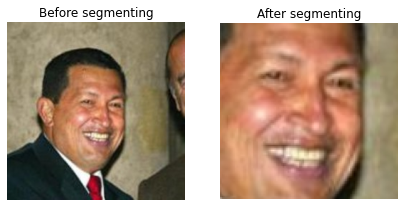

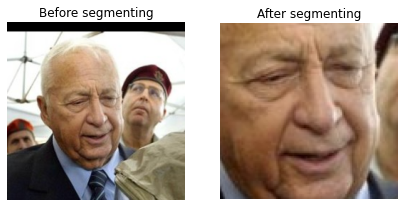

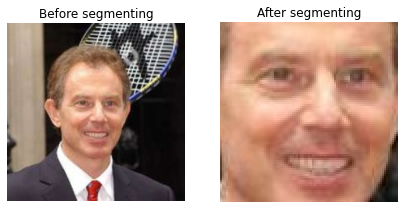

In [45]:
def visualize_segmented(before, after, figure_size=10):
    """
    Function that visualizes a pair. First image in pair is before segmenting and another one after the segmenting
    """
    
    plt.figure(figsize=(figure_size, figure_size))
    
    subplot = plt.subplot(1, 2, 1)
    plt.imshow(before.astype("uint8"))
    plt.title("Before segmenting")
    plt.axis("off")
    
    subplot = plt.subplot(1, 2, 2)
    plt.imshow(after.astype("uint8"))
    plt.title("After segmenting")
    plt.axis("off")

image_batches_segmented_np = normalize_batches_size(image_batches_segmented)
print('Normalized batches array shape', np.shape(image_batches_segmented_np))

visualize_segmented(image_batches[4][3], image_batches_segmented_np[4][3], figure_size=7)
visualize_segmented(image_batches[1][10], image_batches_segmented_np[1][10], figure_size=7)
visualize_segmented(image_batches[2][20], image_batches_segmented_np[2][20], figure_size=7)

**Note!** This line will overwrite the previously formed array `image_batches_numpy`

In [39]:
# Updating image_batches_numpy
image_batches_numpy = image_batches_segmented_np

### Section 2.2. Retrieving the set of features for our images

In [128]:
# Function extracted from keras facenet github
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def extract_vectors_from_batches(image_batches, model, segment_photo=False):
    """
    Feature vectors extraction from image batches
    
    Input:
    image_batches -- a batch of images
    model -- Keras Facenet model
    
    Output:
    vector_batches -- an array of feature vectors for each batch
    """
    
    vector_batches = []
    for batch in image_batches:
        for image_id, image in enumerate(batch):
            resized_image = tf.image.resize(image, [160,160])
            resized_image_np = resized_image.eval(session=tf.compat.v1.Session())
            batch[image_id] = resized_image_np
            
        batch_np = np.array(batch)
        print(batch_np.shape)
        
        batch_np = prewhiten(batch_np)
        vector_batch = model.predict_on_batch(batch_np)
        vector_batches.append(vector_batch)
    
    return vector_batches

**Distance between vectors function**

In [129]:
def feature_vectors_distance(vector1, vector2):
    """
    Returns distance between two given vectors
    
    Input:
    vector1, vector2 -- two vectors
    
    Output:
    distance between vectors
    """
    return np.sum(np.square(vector1 - vector2))

In [130]:
# Getting array of feature vectors
feature_vectors = extract_vectors_from_batches(image_batches_numpy, model=model)

(59, 160, 160, 3)
(59, 160, 160, 3)
(59, 160, 160, 3)
(59, 160, 160, 3)
(59, 160, 160, 3)
(59, 160, 160, 3)
(59, 160, 160, 3)
(59, 160, 160, 3)


In [131]:
def distance_visualize(image1, image2, distance, distance_label=''):
    """
    Function that shows two images and distance between them on the same plot
    
    Input:
    image1, image2 - two images
    distance - distance between images
    
    """
    
    plt.figure(figsize=(5,2))
    # Drawing first picture
    ax = plt.subplot(1, 3, 1)
    plt.imshow(image1.astype("uint8"))
    plt.axis("off")
    # Drawing second picture
    ax = plt.subplot(1, 3, 2)
    plt.imshow(image2.astype("uint8"))
    plt.axis("off")
    # Drawing a distance between them
    ax = plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, 
             str(distance) if len(distance_label) == 0 else distance_label + '=' + str(distance), 
             fontsize='xx-large')
    plt.axis("off")

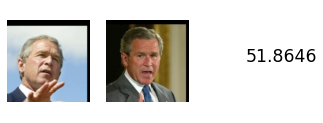

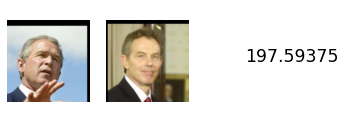

In [135]:
n1, i1, k1, j1 = 0, 0, 0, 6
n2, i2, k2, j2 = 0, 0, 2, 15


distance_visualize(image_batches[n1][i1], 
                   image_batches[k1][j1], 
                   feature_vectors_distance(feature_vectors[n1][i1], feature_vectors[k1][j1]))
distance_visualize(image_batches[n2][i2], 
                   image_batches[k2][j2],
                   feature_vectors_distance(feature_vectors[n2][i2], feature_vectors[k2][j2]))

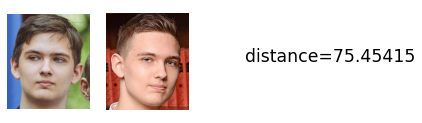

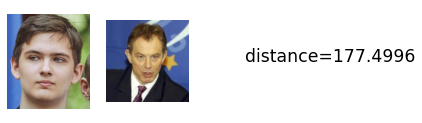

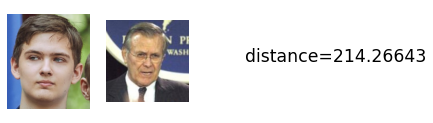

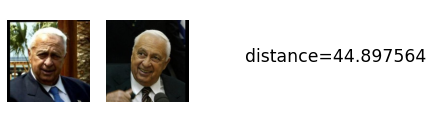

In [136]:
from PIL import Image

def get_image_features(image, model):
    """
    Function that returns array of features for a given image 
    """
    image_resized = tf.image.resize_images(np.expand_dims(image,axis=0), [160,160])
    image_np = image_resized.eval(session=tf.compat.v1.Session())
    image_np = prewhiten(image_np)
    vector_batch = model.predict_on_batch(image_np)
    return vector_batch[0]
    
def get_distance_between_images(image1, image2):
    """
    Function that retrieves the distance between two given images (image1 and image2)
    """
    feature_vector_1 = get_image_features(image1, model)
    feature_vector_2 = get_image_features(image2, model)
    return feature_vectors_distance(feature_vector_1, feature_vector_2)
    
# Read images
person_1 = np.array(Image.open('Images/Dima1.png'))
person_2 = np.array(Image.open('Images/Dima2.png'))

# Visualization of all distances
distance_visualize(person_1, person_2, get_distance_between_images(person_1, person_2), 'distance')
distance_visualize(person_1, image_batches[2][3], get_distance_between_images(person_1, image_batches[2][3]), 'distance')
distance_visualize(person_1, image_batches[3][10], get_distance_between_images(person_1, image_batches[3][10]), 'distance')
distance_visualize(image_batches[1][15], 
                   image_batches[1][30], 
                   get_distance_between_images(image_batches[1][15], image_batches[1][30]), 'distance')

# Section 3. Estimating the accuracy

### 3.1. Forming set of pairs

In [141]:
def get_minimal_batch_size(feature_vectors):
    minimal_batch_size = 10000000
    for batch in feature_vectors:
        minimal_batch_size = min(minimal_batch_size, len(batch))
    
    return minimal_batch_size

def form_pairs_list(feature_vectors_shape, fixed_size = None):
    """
    Forms list of pairs of shape (n_p, 4) where n_p is a number of pairs and 
    each element corresponds to the numbers (n_1, i_1, n_2, i_2)
    
    Input:
    feature_vectors_shape - shape of feature_vectors array
    
    Output: See description of the function
    """
    
    pairs = []
    pairs_number_in_row = int(np.floor(feature_vectors_shape[1]/2))
    
    for batch in range(feature_vectors_shape[0] - 1):
        for i in range(pairs_number_in_row):
            pairs.append([batch, 2*i, batch, 2*i + 1])
        for i in range(pairs_number_in_row):
            pairs.append([batch, i, batch + 1, i])
        
    return pairs

In [143]:
# Forming a list of pairs
pairs = form_pairs_list((len(feature_vectors), get_minimal_batch_size(feature_vectors)))

### 3.2. Finding the best threshold to estimate pair difference

In [144]:
def calculate_pairs_binary_accuracy(pairs, feature_vector_batches, threshold=100):
    """
    Calculates cumulative accuracy by calculating number 
    of successfull recognitions to the total number of guesses
    
    Input:
    pairs -- two-dimensional array each element of which corresponds to [n1, i1, n2, i2]
    feature_vector_batches -- array of feature vectors
    
    Output:
    accuracy -- cumulative accuracy obtained by method described above
    """
    
    accuracies = np.empty((1,0))
    
    for pair in pairs:
        n1, i1, n2, i2 = pair
        distance = feature_vectors_distance(feature_vector_batches[n1][i1], feature_vector_batches[n2][i2])
        if distance < threshold:
            accuracies = np.append(accuracies, float(n1 == n2))
        else:
            accuracies = np.append(accuracies, float(n1 != n2))
        
    return np.mean(accuracies) 

In [145]:
def threshold_accuracies(pairs, feature_vectors, lower_edge=40.0, upper_edge=300.0, step=0.1):
    """
    Function that returns a set of pairs [threshold, binary accuracy for this threshold]
    
    Inputs:
    pairs, feature_vectors -- a set of pairs of form [n1, i1, n2, i2] and a set of feature vectors
    lower_edge, upper_edge -- a value to begin with and iterate until, respectively
    step -- size of step
    
    Outputs:
    threshold -- a vector with all thresholds the function iterates through
    accuracies -- a vector with all corresponding cumulative accuracies
    """
    
    thresholds, accuracies = [], []
    for threshold in np.arange(lower_edge, upper_edge, step):
        thresholds.append(threshold)
        accuracies.append(calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=threshold))
        
    return thresholds, accuracies

def get_best_threshold(pairs, feature_vectors, lower_edge=40.0, upper_edge=300.0, step=0.01):
    """
    Function that returns the threshold with the best binary accuracy
    
    Inputs and outputs:
    Same as for threshold_accuracies function
    
    """
    thresholds, accuracies = threshold_accuracies(pairs, feature_vectors,
                                                  lower_edge=lower_edge, upper_edge=upper_edge, step=step)
    maximum_accuracy_number = np.argmax(accuracies)
    return thresholds[maximum_accuracy_number]

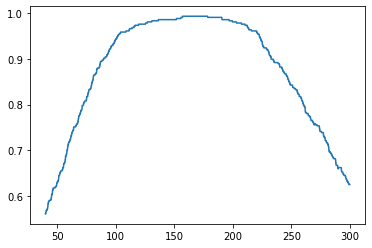

In [147]:
# Getting arrays of threshold and accuracies
thresholds, accuracies = threshold_accuracies(pairs, feature_vectors, lower_edge=40.0, upper_edge=300.0, step=0.1)

# Plotting the values
plt.plot(thresholds, accuracies)
plt.show()

In [ ]:
best_threshold = get_best_threshold(pairs, feature_vectors, lower_edge=40.0, upper_edge=200.0, step=0.1)
print('Best threshold is', best_threshold)
print('Binary accuracy is', calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=best_threshold))

### 3.2. Defining the term "continious accuracy" of pair difference prediction

Now let us estimate roughly what is the accuracy of our algorithm.
Suppose we have $n_b$ batches, every one of which contains $n_i$ images:
$$
(I^{(1)}_1, I^{(1)}_2, \dots, I^{(1)}_{n_i}), (I^{(2)}_1, I^{(2)}_2, \dots\, I^{(2)}_{n_i}), \dots, (I^{(n_b)}_1, \dots, I^{(n_b)}_{n_i})
$$
In other words, $I^{(i)}_j$ is a $j$th image in $i$th batch.

We could probably use binary classification loss functions or F1 score, but we are interested not in the face recognition task, but on the feature vectors themselves as they should not differ significantly.

We will define the following "accuracy" function, where $\tau$ denotes certain threshold (in our case we have put $\tau = 100$):
$$
\alpha(I^{(n_1)}_{i_1}, I^{(n_2)}_{i_2}) = 
\begin{cases}
\max\{1- \left(\frac{d(I^{(n)}_{i_1}, I^{(n)}_{i_2})}{\tau}\right)^{\eta_1}, 0\} \; \text{if} \; n_1 = n_2 = n \\
\max\{1-\left(\frac{\tau}{d(I^{(n_1)}_{i_1}, I^{(n_2)}_{i_2})}\right)^{\eta_2}, 0\} \; \text{if} \; n_1 \neq n_2
\end{cases}
$$

The intuition behind this formula is rather simple: if both images are from the same person, then if the value is less than threshold, then the value interpolates on a segment $[0,1]$ (if distance is close to $0$, thus accuracy is close to $1$, if distance is close to $\tau$, then the accuracy tends to $0$). Same intuition if images are different, but we use the inverse relation to the power of $\eta$.

Suppose we chose $n_p$ pairs of images, each element of which has parameters $p^{(t)} = \{n^{(t)}_1, n^{(t)}_2, i^{(t)}_1, i^{(t)}_2\}$. Then our accuracy equals:
$$
\mathcal{A} = \sqrt{\frac{1}{n_p} \sum_{t=1}^{n_p} \alpha^2(I^{(n^{(t)}_1)}_{i^{(t)}_1}, I^{(n^{(t)}_2)}_{i^{(t)}_2})}
$$

We will select batches so that the number of image pairs from the same batch is the same as the number of pairs from the different batches.

In [ ]:
def calculate_accuracy(same, distance, threshold=100.0, eta_1=3.0, eta_2=3.0):
    """
    Calculates accuracy of distance evaluation based on given distance and whether 
    two images are from one batch 
    
    Inputs:
    same - boolean that equals to True if two images are of a same person and False if vice versa
    distance - distance between two images
    For meaning of other parameters see block above
    
    Output:
    accuracy - calculated value based on the block above
    """
    return max(1 - pow(distance / threshold, eta_1), 0) if same==True else max(1 - pow(threshold/distance, eta_2), 0)   

def calculate_pair_accuracy(feature_vectors, n1, i1, n2, i2, threshold=100, eta_1=3.0, eta_2=3.0):
    """
    Calculates accuracy of distance evaluation between two given pages
    
    Inputs:
    feature_vectors - set of vector batches of shape (n_b, n_i,)
    n1, n2 - number of batch of the first and second image, respectively
    i1, i2 - number of images in the first (n1) and second (n2) batch, respectively
    
    Output:
    accuracy - calculated value based on the block above
    """
    
    distance = feature_vectors_distance(feature_vectors[n1][i1], feature_vectors[n2][i2])
    return calculate_accuracy(n1 == n2, distance, threshold=threshold, eta_1=eta_1, eta_2=eta_2)

In [ ]:
# Checking whether calculation of accuracy is good enough 

# Expected value: 1 - (100/200)^3 = 0.875 
print('If batches are different and distance=200, accuracy equals', calculate_accuracy(False, 200))
# Expected value: 0 
print('If batches are the same and distance=200, accuracy equals', calculate_accuracy(True, 200))
# Expected value: 0
print('If batches are the different and distance=90, accuracy equals', calculate_accuracy(False, 90))
# Expected value: 1 - (64/100)^(3) = 0.737856 
print('If batches are the same and distance=64, accuracy equals', calculate_accuracy(True, 64))

In [ ]:
#Visualization of accuracy between images

distance_visualize(image_batches[0][0], 
                   image_batches[0][1], 
                   calculate_pair_accuracy(feature_vectors, 0, 0, 0, 1, threshold=best_threshold))
distance_visualize(image_batches[0][0], 
                   image_batches[1][0], 
                   calculate_pair_accuracy(feature_vectors, 0, 0, 1, 0, threshold=best_threshold))

In [ ]:
def calculate_pairs_accuracy(pairs, feature_vector_batches, threshold=100):
    """
    Calculates cumulative accuracy after comparing multiple pairs of vectors
    
    Input:
    pairs -- two-dimensional array each element of which corresponds to [n1, i1, n2, i2]
    feature_vector_batches -- array of feature vectors
    
    Output:
    accuracy -- cumulative accuracy
    """
    accuracies = np.empty((1,0))
    
    for pair in pairs:
        n1, i1, n2, i2 = pair
        accuracies = np.append(accuracies, calculate_pair_accuracy(feature_vector_batches, n1, i1, n2, i2, threshold=threshold))
    
    return np.sqrt(np.mean(accuracies**2))     

In [ ]:
accuracy = calculate_pairs_accuracy([[0, 0, 0, 1], [0, 0, 1, 0]], feature_vectors, threshold=best_threshold)
print('Cumulative accuracy for two images above is', accuracy)

In [ ]:
# Getting accuracy
print('Total accuracy is', calculate_pairs_accuracy(pairs, feature_vectors, threshold=best_threshold))
print('Total binary accuracy is', calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=best_threshold))

# Saving the feature vector data to the CSV file

In [ ]:
def form_row_csv(feature_vectors, person_id, image_id):
    """
    Returns an array that corresponds to a single row in the csv file
    """
    
    row = [person_id, image_id]
    return np.append(row, feature_vectors[person_id][image_id])

def form_rows_csv(feature_vectors):
    """
    Returns an array with rows used to load the csv file
    """
    
    rows = []
    for person_id in range(len(feature_vectors)):
        for image_id in range(len(feature_vectors[person_id])):
            rows.append(form_row_for_csv(feature_vectors, person_id, image_id))
            
    return rows

def form_header_csv(vector_dimension):
    """
    Forms a header for the CSV file
    
    Input:
    vector_dimension -- integer that represents the dimensionality of the vector
    """
    
    header = ['person_id', 'image_id']
    for vector_id in range(vector_dimension):
        header.append('feature_' + str(vector_id))
        
    return header

In [ ]:
import csv

# Load the CSV file
with open('datasets/keras_facenet_feature_vectors.csv', 'w') as dataset:
    # Create a writer
    writer = csv.writer(dataset)
    
    # Write a header
    vector_dimension = len(feature_vectors[0][0])
    writer.writerow(form_header_csv(vector_dimension))
    
    # Write rows
    writer.writerows(form_rows_csv(feature_vectors))

# Section 4. Binary string formation 

Suppose we would like to form a binary string $s(I)=s_1s_2\dots s_k$ from a feature vector $\mathbf{f}(I) \in \mathbb{R}^{k}$ of some image $I$:
$$
\mathbf{f}(I) = \begin{bmatrix} f(I)_1 \\ f(I)_2 \\ \dots \\ f(I)_k \end{bmatrix}
$$

Then, we will form the binary string according to the following rule:
$$
s_j = \begin{cases} 1, f(I)_j > 0 \\ 0, f(I)_j \leq 0 \end{cases}
$$

Also we will denote the distance between two binary string $s=s_1s_2\dots s_k$ and $h=h_1h_2 \dots h_k$ as follows:
$$
\delta(s, h) = \frac{1}{k} \sum_{j=1}^k |s_j - h_j|
$$

The similarity of two binary string we will denote as $\sigma(s, h) = 1 - \delta(s,h)$

In [ ]:
def form_string_batches(feature_vectors):
    """
    Function that converts the feature vector batches to the string batches
    
    Input:
    feature_vectors -- array of feature vectors batches
    
    Output:
    string_batches -- array of string batches of the same shape as feature_vectors array
    """
    
    string_batches = []
    
    for batch in feature_vectors:
        string_batch = []
        for feature_vector in batch:
            string_batch.append(form_binary_string(feature_vector))
        
        string_batches.append(string_batch)
    
    return string_batches
        
def form_binary_string(feature_vector):
    """
    Function that forms the binary string according to the rule described above
    """
    
    binary_string = ''
    for vector_element in feature_vector:
        binary_string += ('0' if vector_element <= 0 else '1')
        
    return binary_string

def binary_string_difference(string_1, string_2):
    """
    Function that returns the binary string difference according to the rule described above
    """
    
    assert len(string_1) == len(string_2), 'strings length must match'
    
    total_difference = 0
    for i in range(len(string_1)):
        total_difference += abs(int(string_1[i]) - int(string_2[i]))
    
    return total_difference / len(string_1)

def binary_string_similarity(string_1, string_2):
    """
    Function that returns the binary string difference according to the rule described above
    """
    
    assert len(string_1) == len(string_2), 'strings length must match'
    
    return 1.0 - binary_string_difference(string_1, string_2)

In [ ]:
# Forming the string batches from the feature vectors
string_batches = form_string_batches(feature_vectors)

Using the set of pairs formed before, we can split it into the set of pairs with the same people and with different people (each of size $n_p' = n_p/2$). To get the average similarity between two same or different people, we will simple average the similarity function applied to each pair in the corresponding set, that is:
$$
\sigma_{\text{same/different}} = \frac{1}{n_p'}\sum_{t=1}^{n_p'} \sigma(I_{i_1^{[t]}}^{(n_1^{[t]})}, I_{i_2^{[t]}}^{(n_2^{[t]})})
$$

In [ ]:
def split_pairs(pairs):
    """
    Splits the pairs array into two arrays
    
    Output:
    same_pairs, different_pairs -- pairs of the same person and of two different ones, respectively
    """
    
    same_pairs, different_pairs = [], []
    for pair in pairs:
        n1, _, n2, _ = pair
        if n1 == n2:
            same_pairs.append(pair)
        else:
            different_pairs.append(pair)
            
    return same_pairs, different_pairs

def get_average_similarity(string_batches, pairs):
    """
    Returns average similarity across given pairs
    """
    
    similarities = []
    
    for pair in pairs:
        n1, i1, n2, i2 = pair
        similarities.append(binary_string_similarity(string_batches[n1][i1], string_batches[n2][i2]))
            
    return np.mean(similarities)

In [ ]:
same_pairs, different_pairs = split_pairs(pairs)

print('Average similarity between same person', get_average_similarity(string_batches, same_pairs))
print('Average similarity between different people', get_average_similarity(string_batches, different_pairs))